In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from tqdm import tqdm

In [2]:
def set_seed():
    np.random.seed(20030427)

In [3]:
def simulate_sabr(T, n_steps, F0, alpha_sabr0, beta, rho, nu):
    """
    Simulates a SABR model path using Euler discretization.

    Parameters:
    - T: Total time horizon.
    - n_steps: Number of time steps.
    - F0: Initial forward price.
    - alpha_sabr0: Initial SABR volatility.
    - beta: Elasticity parameter (0 <= beta <= 1).
    - rho: Correlation between price and volatility.
    - nu: Volatility of volatility.

    Returns:
    - t: Time grid.
    - F: Simulated price path.
    - alpha_sabr: Simulated volatility path.
    """
    dt = T / n_steps
    t = np.linspace(0, T, n_steps)
    F = np.zeros(n_steps)
    alpha_sabr = np.zeros(n_steps)
    F[0] = F0
    alpha_sabr[0] = alpha_sabr0
    
    # Generate correlated Brownian motions
    dW1 = np.random.normal(0, np.sqrt(dt), n_steps)
    dW2 = rho * dW1 + np.sqrt(1 - rho**2) * np.random.normal(0, np.sqrt(dt), n_steps)
    
    for i in range(1, n_steps):
        # Prevent division by zero when beta < 1
        if F[i-1] < 1e-8:
            F[i-1] = 1e-8
            
        # Update volatility
        alpha_sabr[i] = alpha_sabr[i-1] + nu * alpha_sabr[i-1] * dW2[i-1]
        alpha_sabr[i] = max(alpha_sabr[i], 1e-6)  # Avoid negative volatility
        
        # Update forward price
        dF = alpha_sabr[i-1] * (F[i-1] ** beta) * dW1[i-1]
        F[i] = F[i-1] + dF
        
    return t, F, alpha_sabr

In [ ]:
import numpy as np
from scipy.stats import norm

def sabr_volatility(F, K, T, alpha_sabr, beta, rho, nu):
    """
    SABR 波动率近似公式 (Hagan et al. 2002)，在 F 约等于 K 时数值稳定
    """
    if abs(F - K) < 3:  # 处理 F ≈ K 的情况
        log_FK = 0  # 近似 log(F/K) ≈ 0
        z = 0
        x = 1  # 避免 x = log((sqrt(1 - 2rho*z + z^2) + z - rho) / (1 - rho)) 计算错误
    else:
        log_FK = np.log(F / K)
        z = (nu / alpha_sabr) * (F * K)**((1 - beta)/2) * log_FK
        x = np.log((np.sqrt(1 - 2*rho*z + z**2) + z - rho) / (1 - rho))
    
    # 计算 SABR 隐含波动率
    A = alpha_sabr / (F**(1 - beta))
    B = 1 + ((1 - beta)**2 * alpha_sabr**2 / (24 * F**(2 - 2*beta)) +
             0.25 * rho * beta * nu * alpha_sabr / (F**(1 - beta)) +
             (2 - 3*rho**2) * nu**2 / 24) * T
    
    if abs(F - K) < 3:  # 处理 F ≈ K 的情况
        vol = A * B  # 避免除 0 问题
    else:
        vol = (A / x) * (z / x) * B  # 正常计算

    return vol




In [ ]:

def sabr_call_price(F, K, T, r, alpha_sabr, beta, rho, nu):
    """
    Computes the European call option price under the SABR model.

    Parameters:
    - F: Forward price.
    - K: Strike price.
    - T: Time to maturity.
    - r: Risk-free rate.
    - alpha_sabr, beta, rho, nu: SABR model parameters.

    Returns:
    - price: Call option price.
    - delta: Delta of the call option.
    """
    vol = sabr_volatility(F, K, T, alpha_sabr, beta, rho, nu)
    d1 = (np.log(F / K) + 0.5 * vol**2 * T) / (vol * np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)
    price = np.exp(-r * T) * (F * norm.cdf(d1) - K * norm.cdf(d2))
    delta = np.exp(-r * T) * norm.cdf(d1)  # Forward Delta
    return price, delta

In [6]:

def sabr_call_price2(F0, K, T, r, alpha_sabr, beta, rho, nu, num_paths=1000, dt=1/252):
    """
    使用蒙特卡洛模拟计算 SABR 模型下的欧式期权价格 & Delta（Classical 和 Bartlett）
    """
    np.random.seed(42)  # 固定随机种子以确保结果可复现
    N = int(T / dt)  # 时间步数
    dW1 = np.random.randn(num_paths, N) * np.sqrt(dt)
    dW2 = np.random.randn(num_paths, N) * np.sqrt(dt)
    
    # 施加相关性
    dW2 = rho * dW1 + np.sqrt(1 - rho**2) * dW2  

    # 初始化路径
    F_paths = np.zeros((num_paths, N+1))
    alpha_paths = np.zeros((num_paths, N+1))
    
    F_paths[:, 0] = F0
    alpha_paths[:, 0] = alpha_sabr
    
    for i in range(N):
        F_paths[:, i+1] = F_paths[:, i] + alpha_paths[:, i] * (F_paths[:, i] ** beta) * dW1[:, i]
        alpha_paths[:, i+1] = alpha_paths[:, i] * np.exp(-0.5 * nu**2 * dt + nu * dW2[:, i])
    
    # 计算终端价格和隐含波动率
    F_T = F_paths[:, -1]
    sigma_T = alpha_paths[:, -1] / (F_T ** (1 - beta))

    # 计算欧式期权价格
    d1 = (np.log(F_T / K) + 0.5 * sigma_T**2 * T) / (sigma_T * np.sqrt(T))
    d2 = d1 - sigma_T * np.sqrt(T)
    
    option_prices = np.exp(-r*T) * (F_T * norm.cdf(d1) - K * norm.cdf(d2))

    # 计算期权价格
    option_price_mc = np.exp(-r * T) * np.mean(np.maximum(F_T - K, 0))

    # 计算 Classical Delta
    delta_mc = np.cov(option_prices, F_T)[0, 1] / np.var(F_T)

    # 计算 Vega
    vega_mc = np.cov(option_prices, sigma_T)[0, 1] / np.var(sigma_T)

    # 计算 dVol/dF（基于 SABR 近似公式）
    dvol_dF = np.mean((sigma_T / F_T) * (1 - beta) / 2 + (rho * nu * alpha_sabr) / F_T)
    #print(dvol_dF)
    # 计算 Bartlett Delta
    delta_bartlett_mc = delta_mc + vega_mc * dvol_dF
    
    return option_price_mc, delta_mc, delta_bartlett_mc



In [7]:
def simulate_observed_price(X, alpha, eta, L=1):
    
    P = np.zeros_like(X)
    P[0] = np.round(X[0] / alpha) * alpha
    change_indices = [0]

    for i in range(1, len(X)):
        # 使用第一版的阈值计算方式
        upper_threshold = P[i-1] + alpha * (L - 0.5 + eta)
        lower_threshold = P[i-1] - alpha * (L - 0.5 + eta)
        
        # 直接比较有效价格与阈值
        if X[i] >= upper_threshold:
            P[i] = P[i-1] + L * alpha
            change_indices.append(i)
        elif X[i] <= lower_threshold:
            P[i] = P[i-1] - L * alpha
            change_indices.append(i)
        else:
            P[i] = P[i-1]
    
    return  X, P, change_indices

In [8]:
from matplotlib.ticker import ScalarFormatter

def plot_uncertainty_zone_matplotlib(X,alpha, eta):
    set_seed()
    
    X, P, change_indices = simulate_observed_price(X,alpha,eta)
    # Set seaborn style
    sns.set_style("whitegrid")

    # Initialize plot
    plt.figure(figsize=(16, 6))
    plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    plt.ticklabel_format(style="plain", axis="y")  
    
    # Plot efficient price and observed price
    sns.lineplot(x=t, y=X, label="Efficient Price", color="blue", linewidth=1)
    sns.lineplot(x=t, y=P, label="Observed Price", color="red", linestyle="--", linewidth=1, drawstyle="steps-post")

    # Compute mid prices and uncertainty zone boundaries
    mid_prices = np.zeros_like(X)
    lower_bounds = np.zeros_like(X)
    upper_bounds = np.zeros_like(X)
    shaded_lower = np.full_like(X, np.nan)
    shaded_upper = np.full_like(X, np.nan)

    for i in range(len(X)):
        k = np.round(X[i] / alpha)  # Closest tick level
        mid_prices[i] = (k - 0.5) * alpha  # Mid price between two adjacent ticks
        lower_bounds[i] = mid_prices[i] - alpha * ( eta)
        upper_bounds[i] = mid_prices[i] + alpha * ( eta)

    # Add grid lines at all mid prices, lower, and upper bounds
    all_mid_prices = np.unique(mid_prices)  # Get unique mid price levels
    all_lower_bounds = np.unique(lower_bounds)  # Get unique lower bounds
    all_upper_bounds = np.unique(upper_bounds)  # Get unique upper bounds


    # Draw horizontal grid lines for each level
    for level in all_mid_prices:
        plt.axhline(y=level, color="green", linestyle="-", linewidth=0.5, alpha=0.5)

    for level in all_lower_bounds:
        plt.axhline(y=level, color="orange", linestyle="-", linewidth=0.5, alpha=0.5)

    for level in all_upper_bounds:
        plt.axhline(y=level, color="orange", linestyle="-", linewidth=0.5, alpha=0.5)

    for i in range(len(change_indices) - 1):
        start = change_indices[i]
        end = change_indices[i + 1]
        #mid_price_at_start = mid_prices[start]
        #lower_at_start = mid_price_at_start - alpha * (eta)
        #upper_at_start = mid_price_at_start + alpha * (eta)
        #shaded_lower[start:end] = lower_at_start
        #shaded_upper[start:end] = upper_at_start+alpha

        # Shaded area for uncertainty zones
        #plt.fill_between(t[start:end], lower_at_start, upper_at_start+alpha, color="gray", alpha=0.2)
        #plt.fill_between(t, shaded_lower, shaded_upper, color="lightgray", alpha=0.1)

        # Vertical lines at price change points
        #plt.axvline(x=t[start], color="gray", linestyle=":", linewidth=0.5, alpha=0.5)
        mid_price = mid_prices[start]
        lower = mid_price - alpha * eta
        upper = mid_price + alpha * eta+alpha

        # 填充矩形区域（只填充当前 step）
        plt.fill_between(t[start:end+1], lower, upper, color="gray", alpha=0.2, step="post",edgecolor="none")


    # Labels and title
    plt.xlabel("Time", fontsize=14)
    plt.ylabel("Price", fontsize=14)
    plt.title("Efficient vs Observed Price with Mid Price and Uncertainty Zone Grid", fontsize=16)
    plt.legend(fontsize=12)

    # Show plot
    plt.show()



In [9]:
SABR_PARAMS = {
    'F0': 100.0,        # 初始价格
    'alpha_sabr0': 0.01,  # 初始波动率 (原alpha0)
    'beta': 1,        # 弹性常数
    'rho': 0.2,         # 价格与波动率的相关系数
    'nu': 0.05,          # 波动率的波动率
}

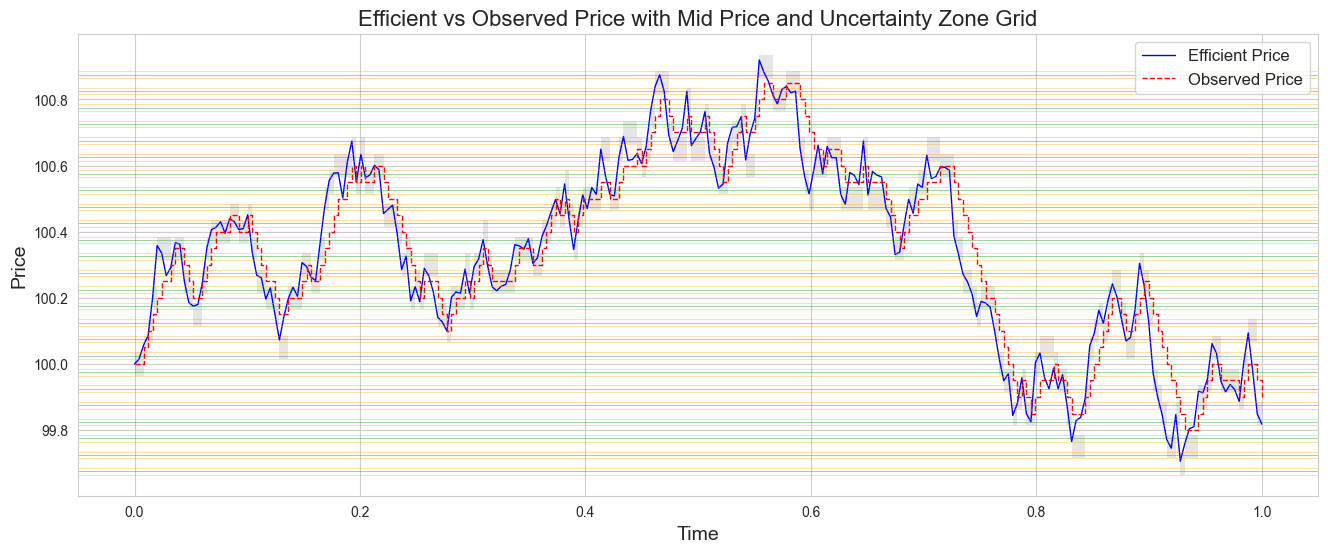

In [10]:
alpha = 0.05      # Tick size
eta = 0.2       # Uncertainty zone width
T = 1.0          # Time horizon
alpha_sabr0 = 0.01  # Volatility, sigma=0.01  5/np.sqrt(252)
F0 = 100      # Initial price
n_steps = 250   # Number of time steps
K = 100 # Strike
number_of_paths = 100 # For Monto Carlo
beta = 1
rho = 0.2
nu = 0.05
t, F, alpha1 = simulate_sabr(T, n_steps, F0, alpha_sabr0,beta,rho,nu)
plot_uncertainty_zone_matplotlib(F,alpha,eta)

In [ ]:
eta = 0.05  # Uncertainty zone width
n_steps = 500

In [12]:
def get_optimal_tau(X, alpha, eta):
    tau = [0]
    l = int(round(alpha**(-0.5)))  # 取最近的整数
    current_zone = (X[0] // alpha) * alpha
    threshold = alpha * (l - 0.5 + eta)
    
    for i in range(1, len(X)):
        upper = current_zone + threshold
        lower = current_zone - threshold
        if X[i] > upper or X[i] < lower:
            tau.append(i)
            current_zone = (X[i] // alpha) * alpha
    return tau

In [14]:
def calculate_hedging_error1(t, X, P, tau, K, params, use_efficient_price=True):
    """对冲误差计算函数"""
    T_total = t[-1]
    portfolio = np.zeros(len(tau))
    positions = np.zeros(len(tau))
    calls = np.zeros(len(tau))
    
    # 初始头寸
    calls[0], positions[0] = sabr_call_price(
        X[tau[0]], K, T_total - t[tau[0]], 0,
        params['alpha_sabr0'], params['beta'],
        params['rho'], params['nu']
    )
    
    # 动态对冲过程
    for j in range(1, len(tau)):
        price_change = X[tau[j]] - X[tau[j-1]] if use_efficient_price else P[tau[j]] - P[tau[j-1]]
        portfolio[j] = portfolio[j-1] + positions[j-1] * price_change
        
        # 更新期权价格和Delta
        remaining_T = T_total - t[tau[j]]
        calls[j], positions[j] = sabr_call_price(
            X[tau[j]], K, remaining_T, 0,
            params['alpha_sabr0'], params['beta'],
            params['rho'], params['nu']
        )
    
    return calls[-1] - portfolio[-1]

In [15]:
def calculate_hedging_error(t, X, alpha_sabr_path, P, tau, K, params, use_efficient_price=True):
    T_total = t[-1]
    portfolio = np.zeros(len(tau))
    positions = np.zeros(len(tau))
    calls = np.zeros(len(tau))
    
    # 初始头寸
    
    calls[0], positions[0]= sabr_call_price(
        X[tau[0]], K, T_total - t[tau[0]], 0,
        params['alpha_sabr0'], params['beta'],
        params['rho'], params['nu']
    )
    
    for j in range(1, len(tau)):
        # 获取当前波动率参数
        alpha_sabr = alpha_sabr_path[tau[j]]
        
        # 计算价格变化（包含波动率变化影响）
        if use_efficient_price:
            dF = X[tau[j]] - X[tau[j-1]]
            dalpha = alpha_sabr - alpha_sabr_path[tau[j-1]]
        else:
            dF = P[tau[j]] - P[tau[j-1]]
            dalpha = 0  # 观测价格不反映真实波动率变化
            
        # Bartlett对冲需要同时考虑价格和波动率变化
        portfolio[j] = portfolio[j-1] + positions[j-1] * (dF + 0.5*dalpha)  # 简化假设
        
        # 更新头寸
        remaining_T = T_total - t[tau[j]]
        #print(X[tau[j]],K, T_total - t[tau[0]], 0,alpha_sabr, params['beta'],params['rho'], params['nu'])
        calls[j], positions[j] = sabr_call_price(X[tau[j]], K, remaining_T, 0,alpha_sabr, params['beta'],params['rho'], params['nu'])
    #print(calls)
    plt.plot(t[tau], portfolio, label = 'Portfolio value at stopping time')
    plt.plot(t[tau], calls, label = 'Call option price at stopping time')
    
    return calls[-1] - portfolio[-1]

In [16]:
def generate_observed_prices(X, tau, alpha):
    """基于退出时间生成观测价格"""
    P = np.zeros_like(X)
    current_p = None
    for i in range(len(X)):
        if i in tau:
            current_p = np.round(X[i] / alpha) * alpha
        P[i] = current_p if current_p is not None else X[0]
    return P

In [17]:
sabr_call_price(100.1 ,100 ,1.0 ,0 ,0.04837420293443696 ,1 ,0.2 ,0.05)

(np.float64(1.9816514876759044), np.float64(0.5178865909468188))

/var/folders/9t/9j621j7x7jzc0wvhlbr8tcjh0000gn/T/ipykernel_53729/2358448955.py:39: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(F / K) + 0.5 * vol**2 * T) / (vol * np.sqrt(T))


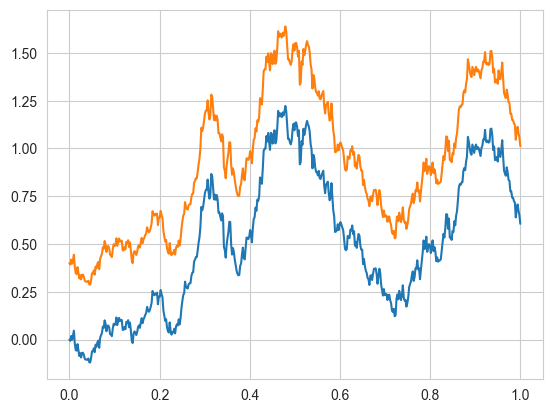

In [18]:
error = [0,0,0]
for i in range(1):
    # Simulate SABR price path
    t, X, alpha_sabr_t = simulate_sabr(T, n_steps, F0, alpha_sabr0, beta, rho, nu)
    #print(get_optimal_tau(X, alpha, eta))
    # Simulate observed price process
    _, P_fixed, tau_fixed = simulate_observed_price(X, alpha, eta)
    tau_optimal = get_optimal_tau(X, alpha, eta)
    P_optimal = generate_observed_prices(X, tau_optimal, alpha)
    #print(tau_optimal)
    # Compute hedging errors for different strategies
    error[1] = calculate_hedging_error(t, X, alpha_sabr_t, X, np.arange(len(t)),K, SABR_PARAMS, True)
    #error[2] = calculate_hedging_error(t, X, alpha_sabr_t, P_fixed, tau_fixed, K, SABR_PARAMS, False)
    #error[0] = calculate_hedging_error(t, X, alpha_sabr_t, P_optimal, tau_optimal, K, SABR_PARAMS, False)

In [19]:
error_1 = np.zeros(number_of_paths)  
error_2 = np.zeros(number_of_paths) 
error_3 = np.zeros(number_of_paths)

Processing Paths:   0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/9t/9j621j7x7jzc0wvhlbr8tcjh0000gn/T/ipykernel_53729/2358448955.py:39: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(F / K) + 0.5 * vol**2 * T) / (vol * np.sqrt(T))
Processing Paths: 100%|██████████| 100/100 [00:07<00:00, 13.35it/s]


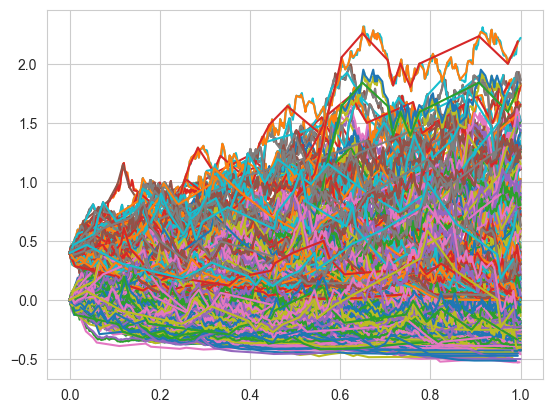

In [20]:
from tqdm import tqdm

for i in tqdm(range(number_of_paths), desc="Processing Paths"):
    # Simulate SABR price path
    t, X, alpha_sabr_t = simulate_sabr(T, n_steps, F0, alpha_sabr0, beta, rho, nu)
    #print(get_optimal_tau(X, alpha, eta))
    # Simulate observed price process
    _, P_fixed, tau_fixed = simulate_observed_price(X, alpha, eta)
    tau_optimal = get_optimal_tau(X, alpha, eta)
    P_optimal = generate_observed_prices(X, tau_optimal, alpha)
    #print(tau_optimal)
    # Compute hedging errors for different strategies
    error_1[i] = calculate_hedging_error(t, X, alpha_sabr_t, X, np.arange(len(t)),K, SABR_PARAMS, True)
    error_2[i] = calculate_hedging_error(t, X, alpha_sabr_t, P_fixed, tau_fixed, K, SABR_PARAMS, False)
    error_3[i] = calculate_hedging_error(t, X, alpha_sabr_t, P_optimal, tau_optimal, K, SABR_PARAMS, False)


In [21]:
print(error_1.mean())
print(error_2.mean())
print(error_3.mean())
print(error_1.std())
print(error_2.std())
print(error_3.std())

0.4015206446390146
0.28576198539850495
0.41517560086831345
0.01653877170295429
0.0496230036747449
0.0470915459543532


In [22]:
error_2

array([0.31010033, 0.21711379, 0.25723993, 0.33199743, 0.3525517 ,
       0.25808744, 0.27576621, 0.33315183, 0.31550627, 0.15469773,
       0.33242569, 0.31826233, 0.33281148, 0.30058224, 0.19141038,
       0.33468764, 0.29617139, 0.28364597, 0.26480148, 0.41215381,
       0.26764112, 0.34941879, 0.29311235, 0.33460406, 0.31567557,
       0.30933734, 0.29299029, 0.27194528, 0.29878111, 0.29517526,
       0.30548499, 0.35048822, 0.34028122, 0.30110198, 0.3113701 ,
       0.28015521, 0.21732399, 0.36682732, 0.22558135, 0.29909608,
       0.31444965, 0.23550426, 0.25501674, 0.27836743, 0.31363242,
       0.2108842 , 0.32658987, 0.19585321, 0.27109391, 0.32454888,
       0.26815702, 0.18978229, 0.24224593, 0.35299905, 0.28593897,
       0.19772454, 0.25725968, 0.30875072, 0.22534959, 0.29640722,
       0.21491389, 0.31683426, 0.28339688, 0.24243787, 0.30008549,
       0.30320318, 0.32255161, 0.23650369, 0.32531533, 0.31931275,
       0.34963245, 0.33645797, 0.35046184, 0.27520767, 0.27615

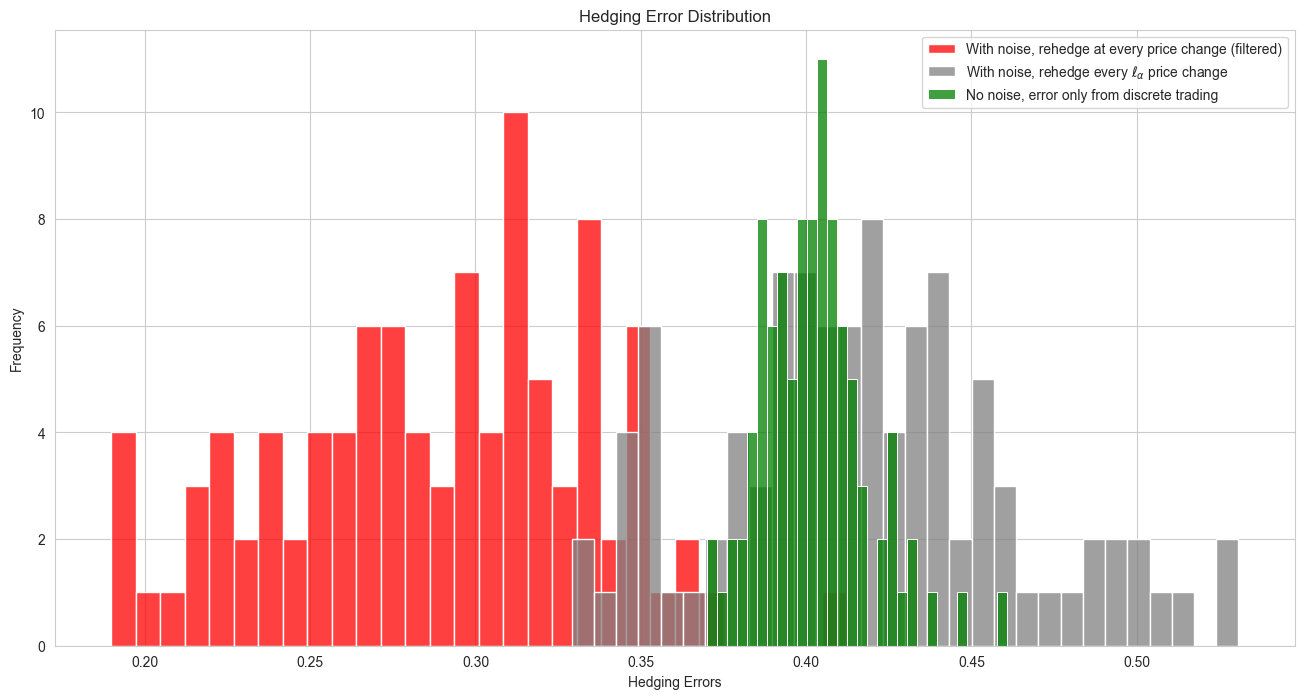

In [23]:
# Define a threshold for small values
threshold = np.percentile(error_2, 2)  # Remove values below the 1st percentile

# Filter out very small values in error_2
filtered_error_2 = error_2[error_2 > threshold]
threshold = np.percentile(error_3, 2)  # Remove values below the 1st percentile

# Filter out very small values in error_2
filtered_error_3 = error_3[error_3 > threshold]
threshold = np.percentile(error_1, 2)  # Remove values below the 1st percentile

# Filter out very small values in error_2
filtered_error_1 = error_1[error_1 > threshold]
sns.set_style("whitegrid")

# Plot histogram
plt.figure(figsize=(16, 8))
sns.histplot(filtered_error_2, label="With noise, rehedge at every price change (filtered)", bins=30, color='red', stat='count', legend=True)
sns.histplot(filtered_error_3, label=r"With noise, rehedge every $\ell_\alpha$ price change", bins=30, color='grey', stat='count', legend=True)
sns.histplot(filtered_error_1, label="No noise, error only from discrete trading", bins=30, color='green', stat='count', legend=True)

# Labels and Title
plt.xlabel("Hedging Errors")
plt.ylabel("Frequency")
plt.title("Hedging Error Distribution")
plt.legend()
plt.savefig("hedgingError_filtered.pdf", format="pdf")

# Show plot
plt.show()
